### 线性回归的从零开始实现

![image-20221225225313276](https://picgo-1306750321.cos.ap-guangzhou.myqcloud.com/image-20221225225313276.png)

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [3]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声。"""
    X = d2l.torch.normal(0, 1, (num_examples, len(w)))

    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([ 0.5176, -1.1382]) 
label: tensor([9.0941])


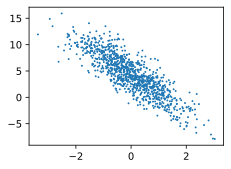

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

![image-20221225230800569](https://picgo-1306750321.cos.ap-guangzhou.myqcloud.com/image-20221225230800569.png)

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，不是按顺序读取的
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-0.8946, -0.8145],
        [-1.6824, -0.7374],
        [-0.6956, -0.0430],
        [ 0.0266,  1.4711],
        [ 0.3323,  0.5602],
        [ 0.9734,  1.0143],
        [-1.1084, -0.3631],
        [ 0.5811, -0.7667],
        [-0.6199,  0.3382],
        [-1.2907, -1.4003]]) tensor([[ 5.1832],
        [ 3.3274],
        [ 2.9407],
        [-0.7561],
        [ 2.9555],
        [ 2.6916],
        [ 3.2106],
        [ 7.9906],
        [ 1.7973],
        [ 6.3901]])


### 定义初始化模型参数

In [7]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def linreg(X, w, b):
    """线性回归模型。"""
    return torch.matmul(X, w) + b

### 定义损失函数

In [8]:
def squared_loss(y_hat, y):
        """均方误差"""
        return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义优化函数

In [9]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降。"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练过程

In [10]:
lr = 0.03 # 学习率
num_epochs = 3 # 训练周期
net = linreg # 线性回归模型
loss = squared_loss # 均方误差

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # 'x' 和 'y' 的小批量损失
        # 因为 'l'形状是 ('batch_size', 1)，而不是一个标量
        # 并以此计算关于 [w, b] 的梯度
        l.sum().backward()
        sgd([w,b] , lr, batch_size) # 使用小批量随机梯度下降迭代模型参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')



epoch 1, loss 0.035198
epoch 2, loss 0.000118
epoch 3, loss 0.000048


### 线性回归的简洁实现

In [11]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b,1000)

In [12]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器。"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[ 1.6326,  0.7222],
         [-0.0331,  0.4539],
         [ 0.4163,  0.1080],
         [-1.2484, -0.5217],
         [ 0.0976, -0.6184],
         [ 1.2160,  0.2138],
         [-0.1009,  1.2888],
         [ 0.6740, -0.3929],
         [ 0.8580, -0.2436],
         [-0.9949, -1.1369]]),
 tensor([[ 5.0044],
         [ 2.5958],
         [ 4.6738],
         [ 3.4715],
         [ 6.5111],
         [ 5.9100],
         [-0.3941],
         [ 6.8907],
         [ 6.7484],
         [ 6.0810]])]

### 模型定义

### 使用框架的预定好的层

In [13]:
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))  # 定义模型

### 初始化模型参数

In [14]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 计算均方误差使用的是MSELoss类

In [15]:
loss = nn.MSELoss()

### 实例化SGD优化器

In [18]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)


### 训练过程

In [19]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
print(f'epoch {epoch + 1}, loss {l:f}')

epoch 3, loss 0.000095
